In [ ]:
library(rio)
library(tidyverse)
library(smwrData)
library(smwrBase)
library(smwrGraphs)
library(scales)
library(corrplot)
library(factoextra)

In [2]:
theme_glab = function(
    base_size=12,
    base_family="",
    base_line_size=base_size / 180,
    base_rect_size=base_size / 180
) {

    # Assign font family up front
    font = "Helvetica"

    ggplot2::theme_bw(
        base_size=base_size, 
        base_family=base_family,
        base_line_size=base_line_size
    ) %+replace%
    ggplot2::theme(
        legend.background=element_blank(),
        legend.title=element_text(
            color=rgb(100, 100, 100, maxColorValue=255),
            size=rel(0.65),
            hjust=0
        ),
        legend.text=element_text(
            color=rgb(100, 100, 100, maxColorValue=255),
            size=rel(0.65)
        ),
        legend.key.size=unit(0.8, "lines"),
        plot.title=element_text(
            color=rgb(100, 100, 100, maxColorValue=255), 
            hjust=0
        ),
        axis.title=element_text(
            color=rgb(100, 100, 100, maxColorValue=255),
            size=rel(0.65)
        ),
        axis.text=element_text(
            color=rgb(100, 100, 100, maxColorValue=255),
            size=rel(0.65)
        ),
        plot.caption=element_text(
            color=rgb(100, 100, 100, maxColorValue=255),
            size=rel(0.35),
            hjust=1
        ), 
        panel.grid.major=element_blank(),   
        panel.grid.minor=element_blank(),   
        panel.border=element_rect(
            colour=rgb(100, 100, 100, maxColorValue=255),
            fill=NA
        ),
        complete=TRUE
    )
}

In [ ]:
# Load all helper functions
loaded_scripts = sapply(list.files("../R/", full.names=TRUE), source)

In [4]:
PROJECT_NAME = "ARG23"

DATA_DIR = "../data/"

## Load project's *env_dataset*

In [ ]:
data_df = import(
    file=file.path(
        DATA_DIR,
        paste0(PROJECT_NAME, "_env_dataset.xlsx")
    ),
    sheet="envdata_template",
    skip=1
)

# Remove first row containing the units
data_df = data_df %>% slice(2:nrow(data_df))

# Convert data columns to numeric
data_df = type.convert(data_df, as.is=TRUE)

# Convert SiteID to ordered factor for plotting
data_df = data_df %>% mutate(SiteID=factor(SiteID, levels=data_df$SiteID))

In [6]:
data_df

ExpID,SiteID,CollectionID,site_name,series,continent,country,year,date,StrataID,⋯,DHS,DV,HF,PV,SR,slab_name,SDepth,SDip,ConvR,ConvAge
<chr>,<fct>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,⋯,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
ARG23,ES,ES230304,El Sauce,1,SA,ARG,2023,45019.0,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ARG23,OZ,OZ230305,Olaruz,2,SA,ARG,2023,45049.0,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ARG23,RC1,RC1230306,Rosario de Coyaguima,3,SA,ARG,2023,45080.0,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ARG23,PQ,PQ230306,Pairique,4,SA,ARG,2023,45080.0,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ARG23,CZ,CZ230307,Coranzuli,5,SA,ARG,2023,45110.0,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ARG23,PI,PI230308,Pirquitas,6,SA,ARG,2023,45141.0,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ARG23,OY,OY230308,Orosmayo,7,SA,ARG,2023,45141.0,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ARG23,LF,LF230308,Lagunilla del Farallon,8,SA,ARG,2023,45141.0,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
ARG23,LV,LV230309,Laguna de Vilama,9,SA,ARG,2023,45172.0,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


## DIC analysis

In [ ]:
figure_dic = ggplot(
        data=data_df,
        aes(
            x=SiteID,
            y=d13DIC
        )
    ) +
    geom_boxplot(fill="lightgray") +
    scale_x_discrete(limits=unique(data_df$SiteID)) +
    theme_glab() +
    # Rotate X axis labels
    theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1))

ggsave(
    filename=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-dic.svg")
    ),
    width=7,
    height=7
)

figure_dic

## IC analysis

In [16]:
ion_cols = c(
    "alk_tot",
    "cl",
    "so4",
    "na",
    "k",
    "ca",
    "mg"
)

ic_df = data_df %>%
    # Fill NA (missing ions)
    mutate(across(all_of(ion_cols), ~replace_na(.x, 0))) %>%
    # WARNING: Calculate meq for plotting, concentrations must be in mg/L!!!
    mutate(
        HCO3.meq=alk_tot,
        Cl.meq=cl,
        SO4.meq=so4,
        Na.meq=na,
        K.meq=k,
        Ca.meq=ca,
        Mg.meq=mg
    ) %>%
    # Calculate ion balance
    mutate(
        sum_anions=(HCO3.meq + Cl.meq + SO4.meq),
        sum_cations=(Na.meq + K.meq + Ca.meq + Mg.meq)
    ) %>%
    mutate(
        IB=100 * (sum_cations - sum_anions) / (sum_cations + sum_anions)
    )

ic_df

ExpID,SiteID,CollectionID,site_name,series,continent,country,year,date,StrataID,⋯,HCO3.meq,Cl.meq,SO4.meq,Na.meq,K.meq,Ca.meq,Mg.meq,sum_anions,sum_cations,IB
<chr>,<fct>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<lgl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ARG23,ES,ES230304,El Sauce,1,SA,ARG,2023,45019.0,NA,⋯,765,3805.285,1920.534,3413.427,51.482,147.261,23.053,6490.819,3635.223,-28.20052
ARG23,OZ,OZ230305,Olaruz,2,SA,ARG,2023,45049.0,NA,⋯,417,3358.449,226.590,1898.038,82.002,212.594,100.216,4002.039,2292.850,-27.15201
ARG23,RC1,RC1230306,Rosario de Coyaguima,3,SA,ARG,2023,45080.0,NA,⋯,1029,4654.405,383.785,3088.188,220.677,212.528,37.229,6067.190,3558.622,-26.06085
ARG23,PQ,PQ230306,Pairique,4,SA,ARG,2023,45080.0,NA,⋯,486,368.417,108.029,475.421,7.627,17.701,6.087,962.446,506.836,-31.00902
ARG23,CZ,CZ230307,Coranzuli,5,SA,ARG,2023,45110.0,NA,⋯,312,89.249,26.656,175.147,3.440,23.274,3.820,427.905,205.681,-35.07401
ARG23,PI,PI230308,Pirquitas,6,SA,ARG,2023,45141.0,NA,⋯,2265,8194.413,204.895,5390.473,190.206,345.721,135.562,10664.308,6061.962,-27.51567
ARG23,OY,OY230308,Orosmayo,7,SA,ARG,2023,45141.0,NA,⋯,261,15.452,22.029,117.854,0.646,11.270,4.244,298.481,134.014,-38.02749
ARG23,LF,LF230308,Lagunilla del Farallon,8,SA,ARG,2023,45141.0,NA,⋯,930,2325.151,0.000,1701.202,47.645,145.921,31.021,3255.151,1925.789,-25.65870
ARG23,LV,LV230309,Laguna de Vilama,9,SA,ARG,2023,45172.0,NA,⋯,663,22700.545,1947.880,10966.267,736.896,1003.251,821.218,25311.425,13527.632,-30.34006


#### Ternary plots

Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Ignoring unknown aesthetics: z, zend”
Warning message:
“Ignoring unknown aesthetics: z”


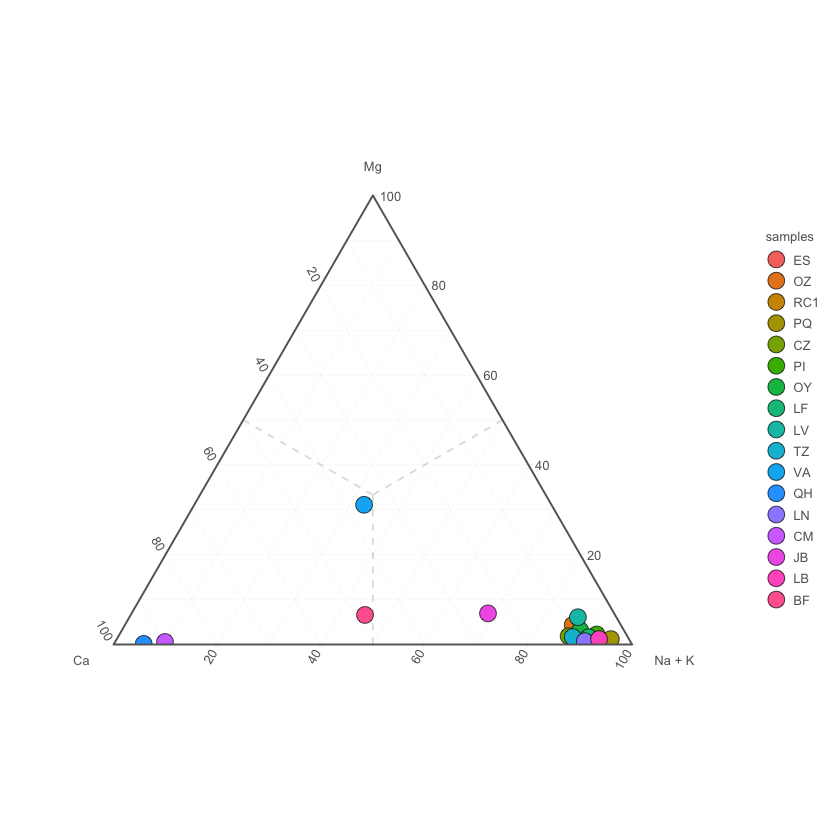

In [9]:
figure_major_cations = plot_base_major_cations() +
    geom_point(
        data=ic_df,
        aes(
            x=Ca.meq,
            y=Mg.meq,
            z=Na.meq + K.meq,
            fill=SiteID
        ),
        size=4.5,
        shape=21,
        stroke=0.3
    ) +
    theme_glab()

ggsave(
    filename=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-major-cations.svg")
    ),
    width=7,
    height=7
)

figure_major_cations

Warning message:
“Ignoring unknown aesthetics: z”


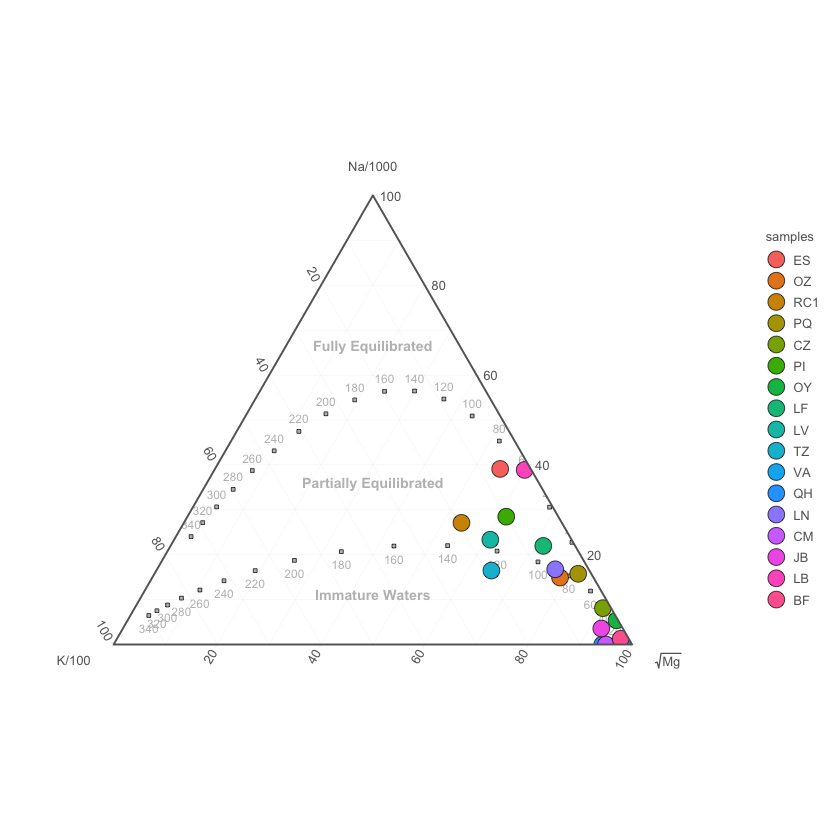

In [10]:
figure_maturity_gigg = plot_base_water_maturity(type="giggenbach") +
    geom_point(
        data=ic_df,
        aes(
            x=k/100,
            y=na/1000,
            z=sqrt(mg),
            fill=SiteID
        ),
        size=4.5,
        shape=21,
        stroke=0.3
    ) +
    theme_glab()

ggsave(
    filename=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-water-maturity-giggenbach.svg")
    ),
    width=7,
    height=7
)

figure_maturity_gigg

Warning message:
“Ignoring unknown aesthetics: z”


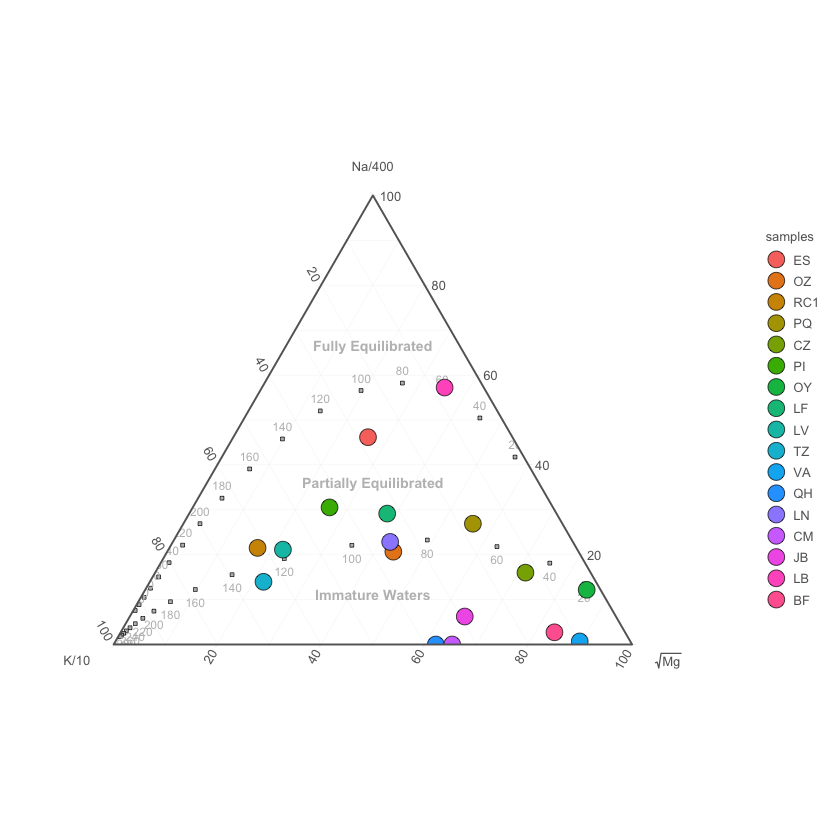

In [11]:
figure_maturity_duchi = plot_base_water_maturity(type="duchi") +
    geom_point(
        data=ic_df,
        aes(
            x=k/10,
            y=na/400,
            z=sqrt(mg),
            fill=SiteID
        ),
        size=4.5,
        shape=21,
        stroke=0.3
    ) +
    theme_glab()

ggsave(
    filename=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-water-maturity-duchi.svg")
    ),
    width=7,
    height=7
)

figure_maturity_duchi

Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Ignoring unknown aesthetics: z, zend”
Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Ignoring unknown aesthetics: z”
Warning message:
“Ignoring unknown aesthetics: z”


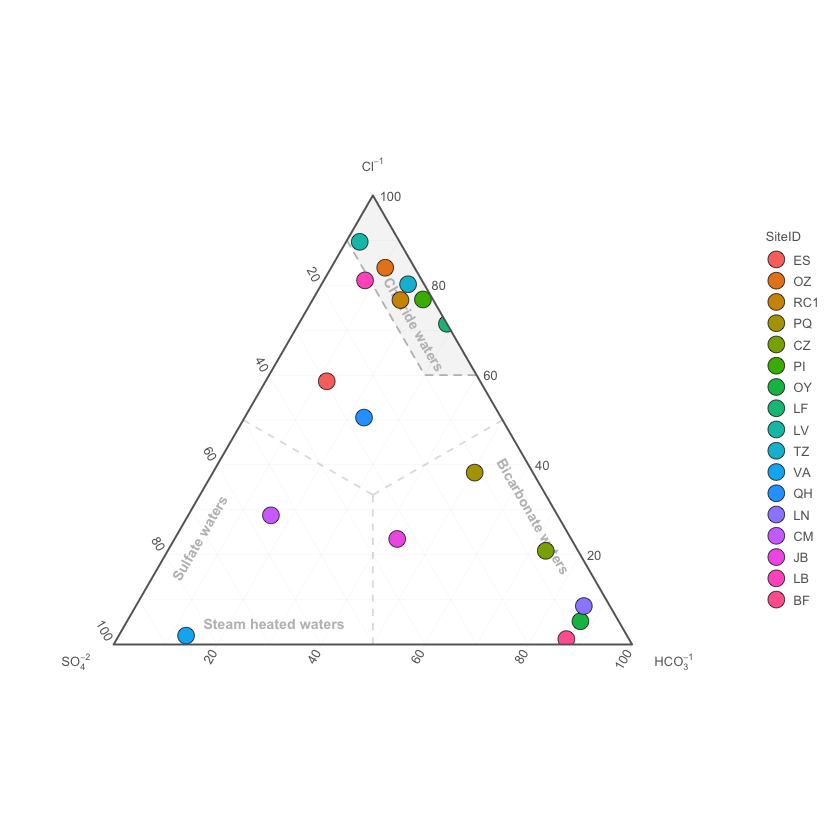

In [12]:
figure_gigg_anions = plot_base_gigg_anions() +
    geom_point(
        data=ic_df,
        aes(
            x=SO4.meq,
            y=Cl.meq,
            z=HCO3.meq,
            fill=SiteID
        ),
        size=4.5,
        shape=21,
        stroke=0.3
    ) +
    theme_glab()

ggsave(
    filename=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-giggenbach-anions.svg")
    ),
    width=7,
    height=7
)

figure_gigg_anions

#### Langelier-Ludwig diagram

In [13]:
# Add anions and cations transformations as columns
ic_df = ic_df %>%
    mutate(
        r_bicarb=50 * (HCO3.meq) / sum(
            HCO3.meq + Cl.meq + SO4.meq
        ),
        r_na_k=50 * (Na.meq + K.meq) / sum(
            Na.meq + K.meq + Mg.meq + Ca.meq
        )
    ) %>%
    mutate(
        r_ca_mg=50 - r_na_k,
        r_cl_so4=50 - r_bicarb
    )


Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Ignoring unknown parameters: linewidth”
Warning message:
“Ignoring unknown parameters: linewidth”


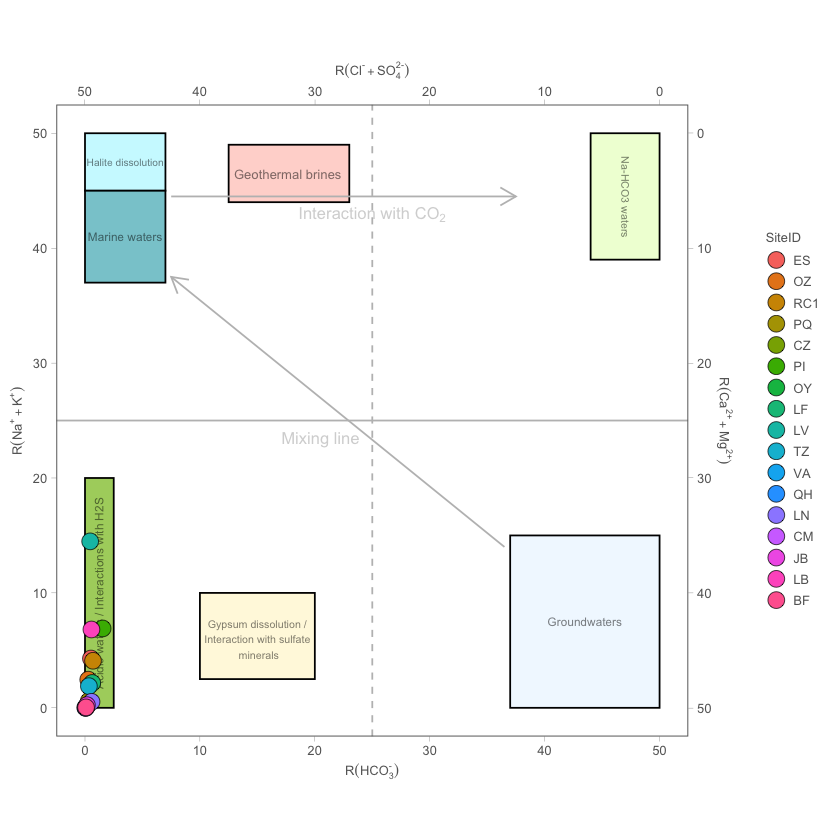

In [14]:
figure_ll = plot_base_ll() +
    geom_point(
        data=ic_df,
        aes(
            x=r_bicarb,
            y=r_na_k,
            fill=SiteID
        ),
        size=4.5,
        shape=21,
        stroke=0.3
    )

ggsave(
    filename=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-langelier-ludwig.svg")
    ),
    width=7,
    height=7
)

figure_ll

#### Piper diagram

In [15]:
setPNG(
    name=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-piper.png")
    ),
    width=7,
    height=7
)

figure_piper = smwrGraphs::piperPlot(
        xCat=ic_df$Ca.meq,
        yCat=ic_df$Mg.meq,
        zCat=ic_df$Na.meq,
        xAn=ic_df$Cl.meq,
        yAn=ic_df$HCO3.meq,
        zAn=ic_df$SO4.meq,
        Plot=list(
            name=ic_df$SiteID,
            color=setColor(hue_pal()(length(unique(ic_df$SiteID))))
        ),
        zCat.title="Sodium",
        xAn.title="Chloride",
        yAn.title="Bicarbonate"
    ) %>%
    addExplanation(
        where="ul",
        title="Piper diagram"
    )

graphics.off()

 width height 
     7      7 
[1] "Setting up markdown graphics device:  ../figures/ARG23-piper.png"


## ICP-MS analysis

In [ ]:
icp_df = process_icp_data(
    file.path(
        DATA_DIR,
        "ICP-MS/ARG23_dil1at10.xlsx"
    )
)

# Discard values that didn't pass the SD check
icp_df = icp_df %>% filter(value_sd_check != "DISCARD")

In [18]:
# Remove selected elements
icp_df = icp_df %>%
    filter(
        element != "Li",
        !(element == "Na" & gas == "No Gas"),
        element != "Mg",
        !(element == "P" & gas == "No Gas"),
        !(element == "S" & gas == "No Gas"),
        element != "K",
        element != "Ca",
        !(element == "Si" & gas == "No Gas")
    )

In [19]:
# Save processed ICP-MS data in wide format
icp_df_wide = icp_df %>%
  ungroup() %>%
  select(sample, element, isotope, dilution, gas, concentration) %>%
  pivot_wider(
    id_cols=c(
      sample,
      dilution,
      gas
    ),
    names_from=c(
      isotope,
      element
    ),
    names_sep="_",
    values_from=concentration
  )

write.csv(
  x=icp_df_wide,
  file=file.path(
    DATA_DIR,
    "ICP-MS/ARG23_dil1at10_processed.csv"
  ),
  row.names=FALSE
)

In [20]:
# Sort samples and put blank first
icp_blank_name = "blank"

icp_sample_order = c(
    icp_blank_name,
    icp_df %>% filter(sample != icp_blank_name) %>% pull(sample) %>% unique()
)

icp_df = icp_df %>%
    mutate(sample=factor(sample, levels=icp_sample_order))

In [21]:
selected_metals = read.csv(
        text="element,color
            Fe,#f57900
            V,#4e9a06
            Mn,#563566
            Co,#204a87
            Ni,#555753
            Cu,#8ae234
            Zn,#babdb6
            Se,#edd400
            Mo,#a40000
            W,#8f5902"
    ) %>%
    # Replace indentation whitespaces
    mutate(
        element=str_replace(
            string=element,
            pattern="\\s+",
            replacement=""
        )
    )

# Create a named vector
selected_metals = selected_metals %>% deframe()

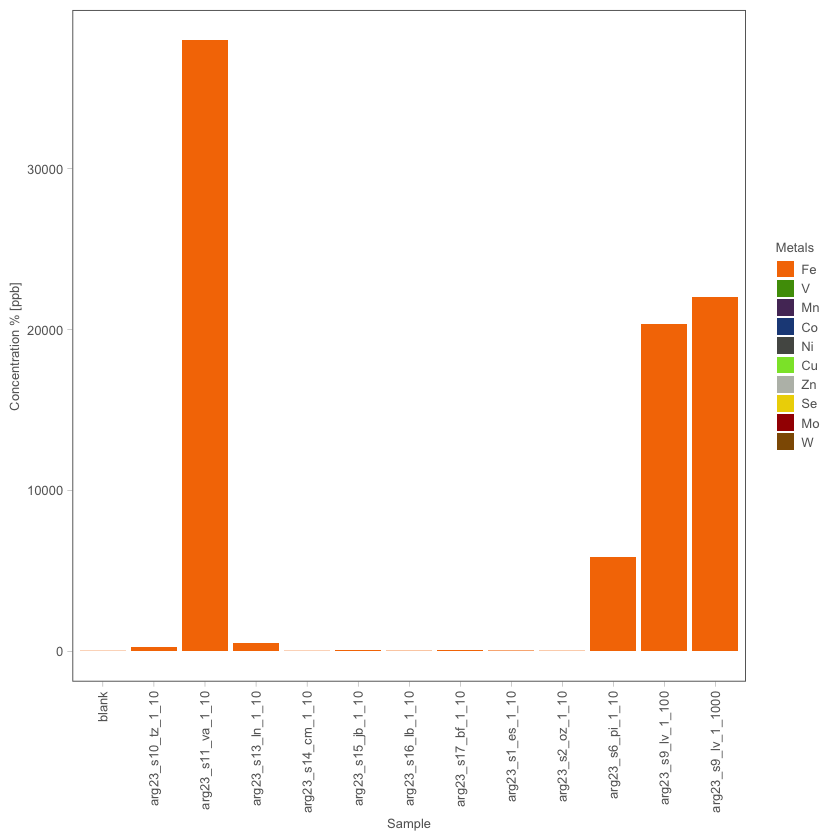

Warning message:
“Removed 1 rows containing missing values (position_stack).”


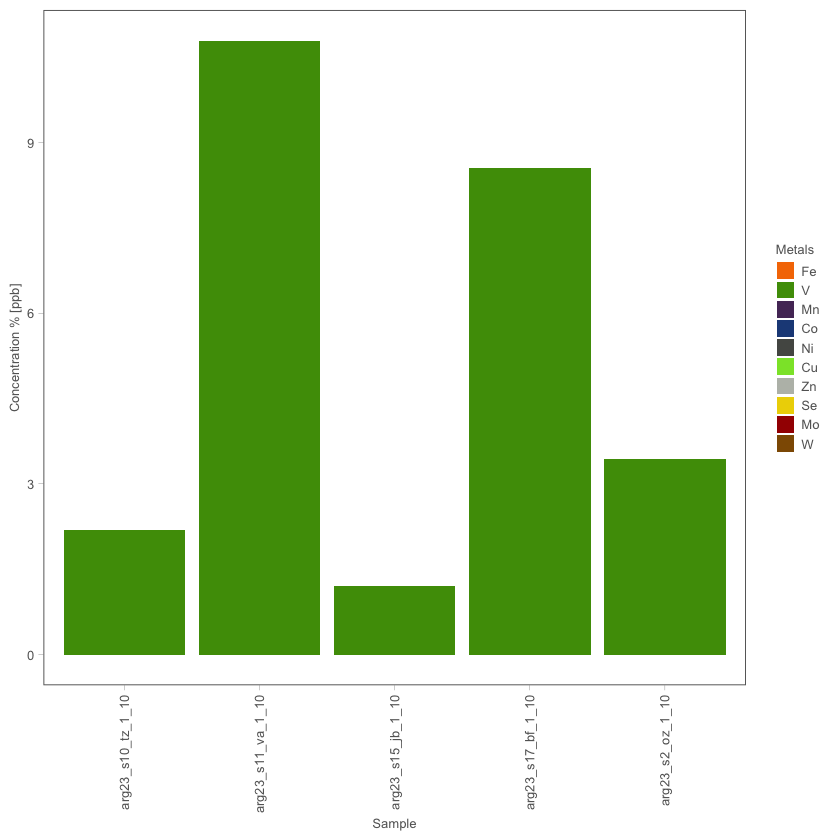

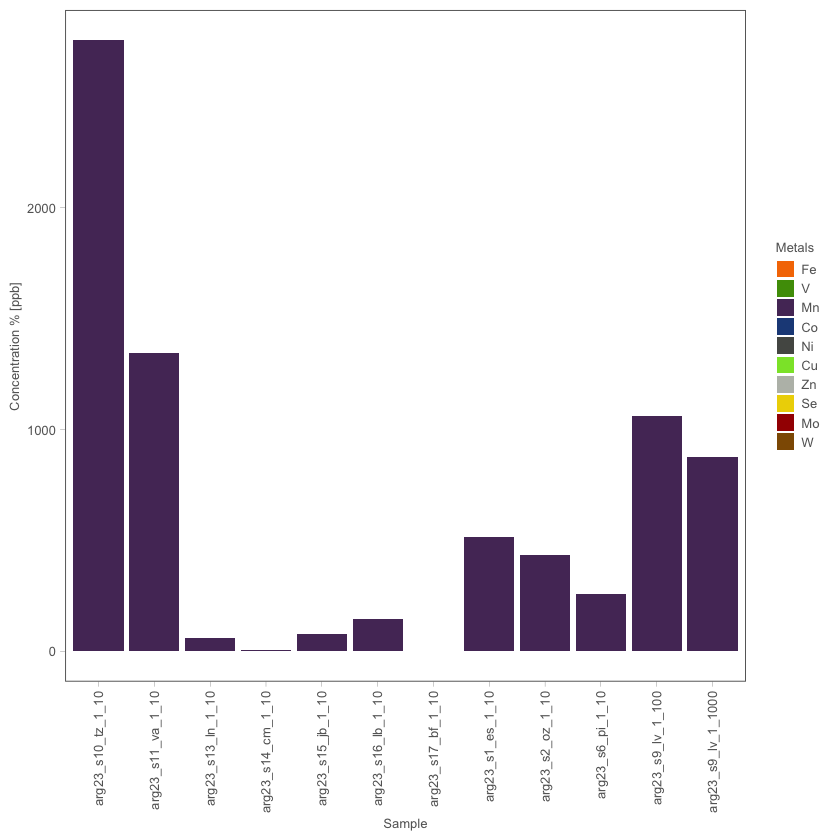

Warning message:
“Removed 9 rows containing missing values (position_stack).”


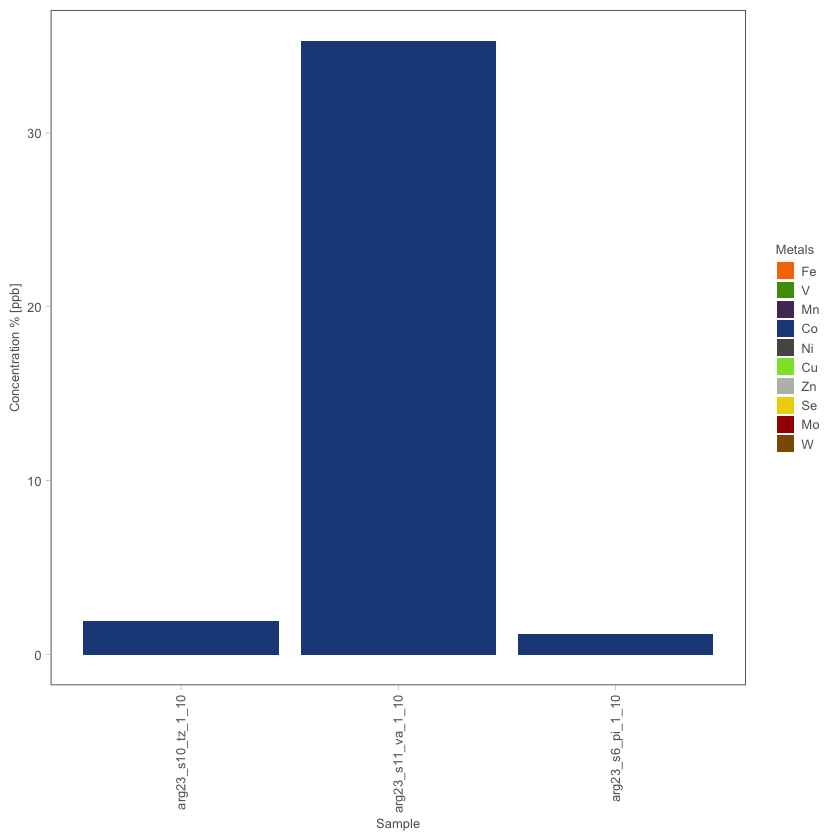

Warning message:
“Removed 6 rows containing missing values (position_stack).”


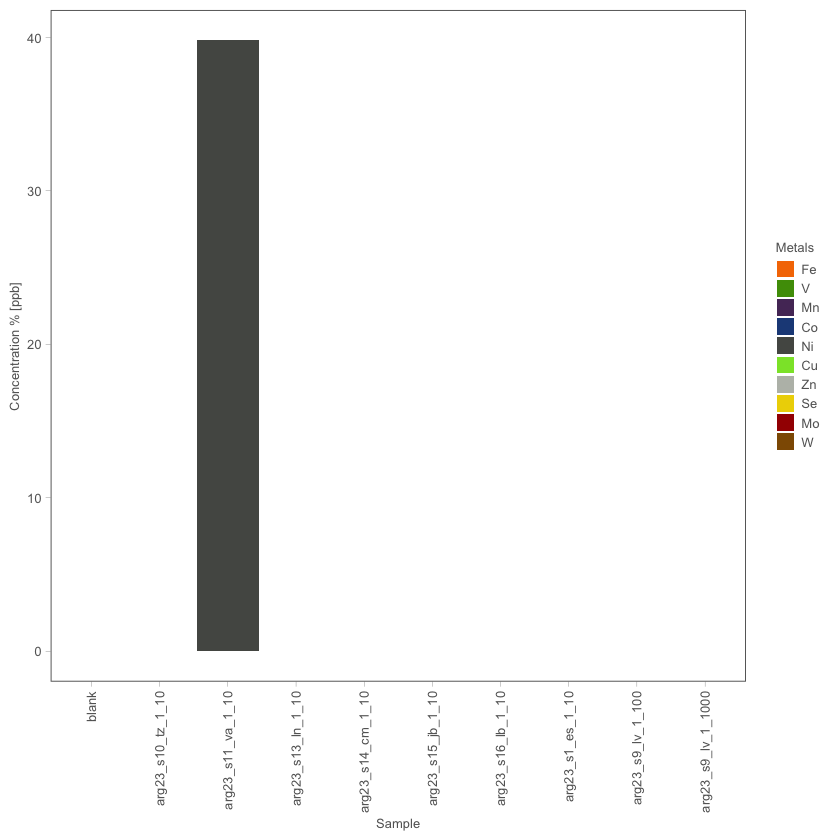

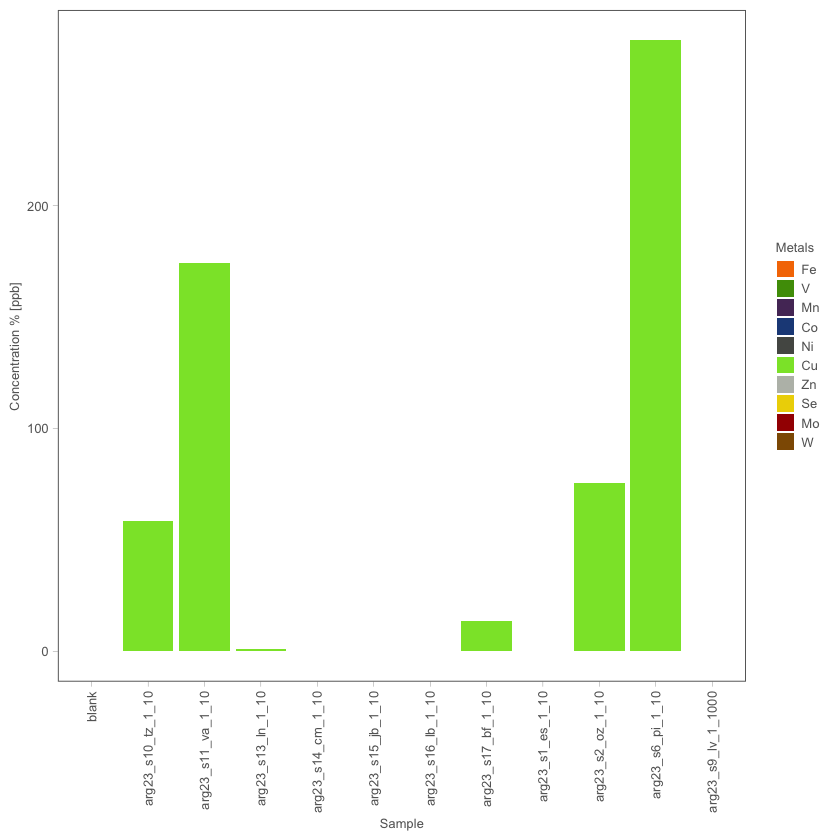

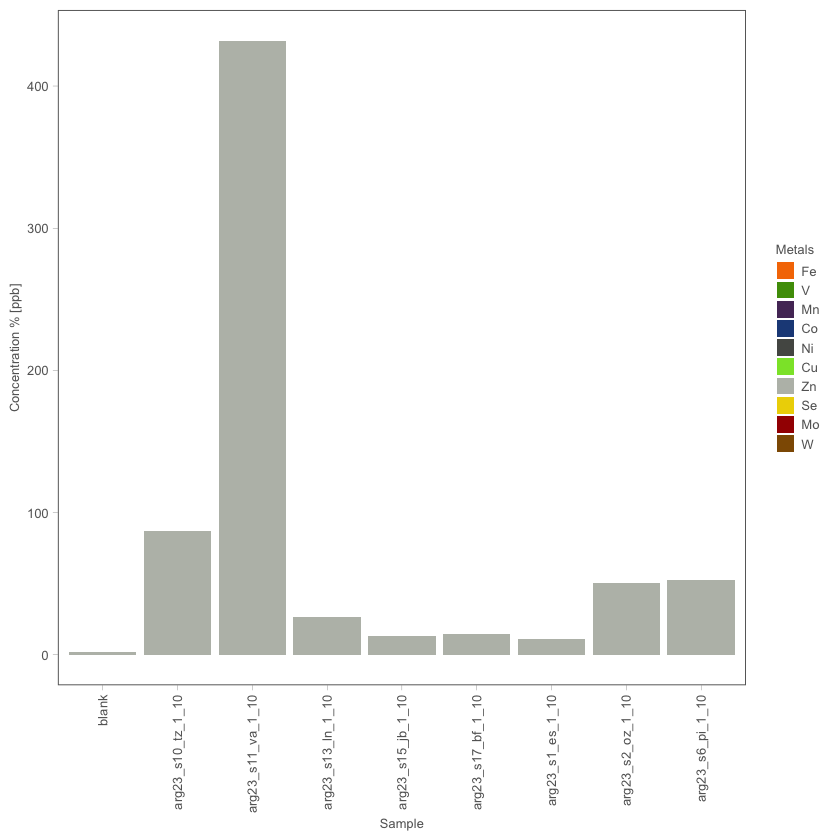

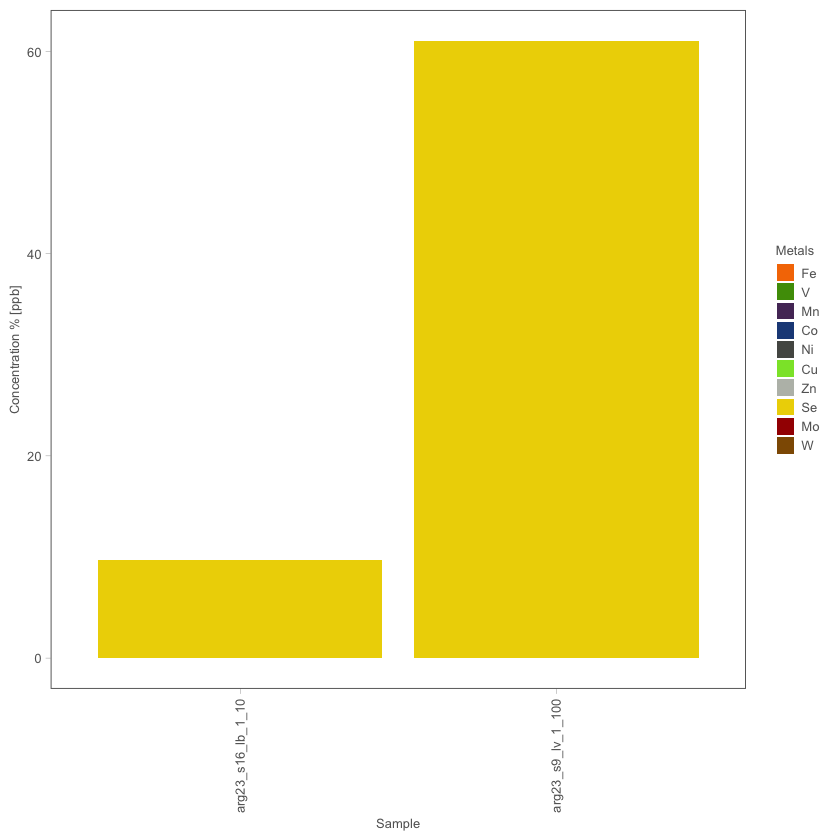

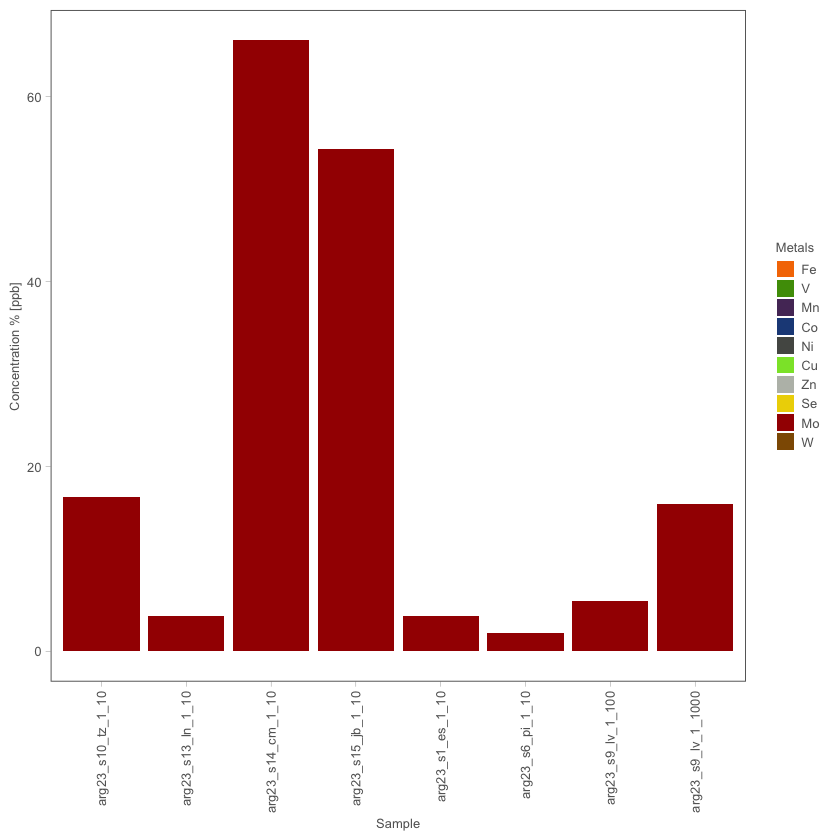

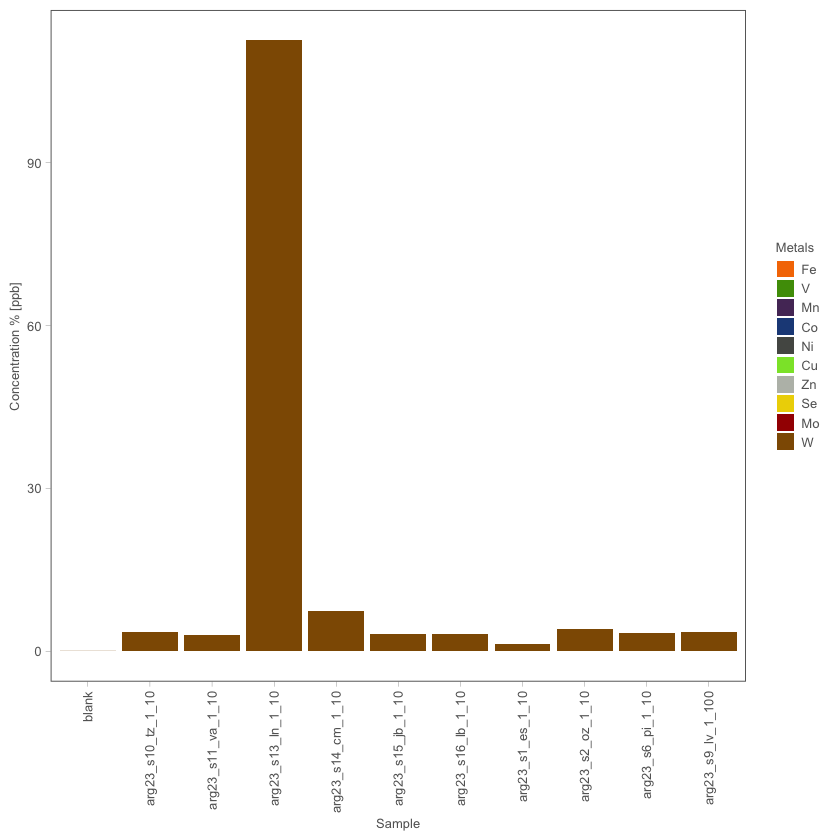

In [21]:
for (element_name in names(selected_metals)) {
    plot_single_metal = ggplot(
        data=icp_df %>% filter(element == element_name),
        aes(fill=element, y=concentration, x=sample)
    ) +
    geom_bar(stat="identity", na.rm=FALSE) +
    theme_glab() +
    theme(axis.text.x=element_text(angle=90, vjust=0.5, hjust=1)) +
    xlab("Sample") +
    ylab("Concentration % [ppb]") +
    scale_colour_manual(
        name="Metals",
        values=selected_metals,
        aesthetics="fill"
    )
    print(plot_single_metal)
}

In [22]:
icp_df_selected = icp_df %>%
    filter(element %in% names(selected_metals))

Warning message:
“Ignoring unknown parameters: stat”
Warning message:
“Removed 16 rows containing missing values (position_stack).”
Warning message:
“Removed 16 rows containing missing values (position_stack).”


TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]

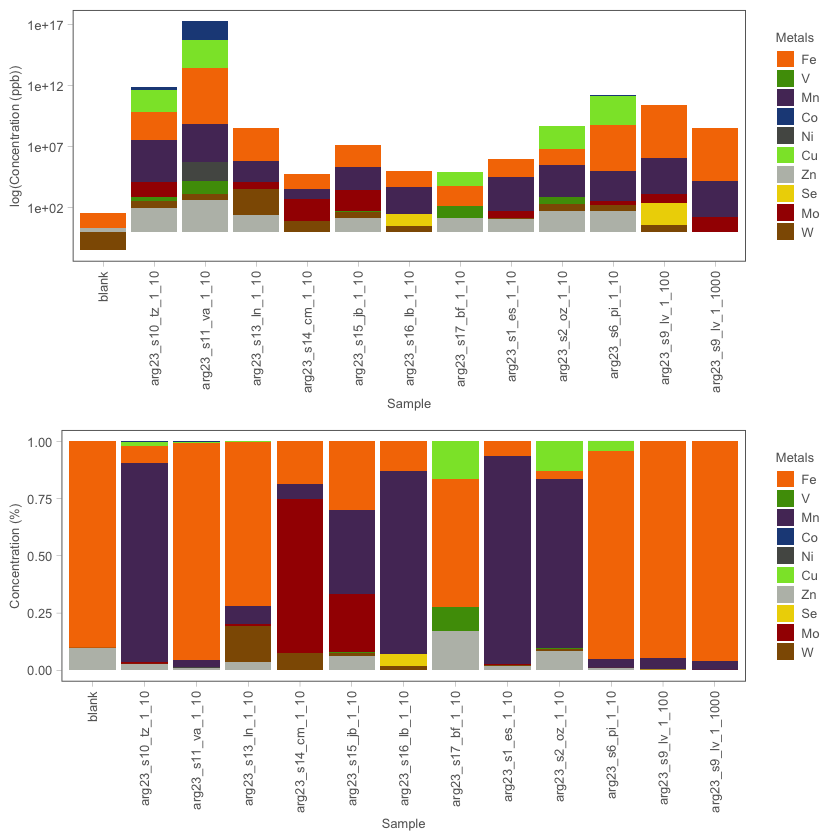

In [36]:
figure_metals_rep = plot_metals(icp_df_selected, log_y=TRUE)

ggsave(
    plot=figure_metals_rep,
    filename=file.path(
        "../figures",
        paste0(PROJECT_NAME, "-metals-rep.svg")
    ),
    width=7,
    height=7
)

figure_metals_rep

In [ ]:
# # WARNING: use only when replicates are present!
# icp_df_selected_avg = icp_df_selected %>%
#     mutate(
#         sample=str_replace(
#             string=sample,
#             pattern="_\\d+$",
#             replacement=""
#         )
#     ) %>%
#     group_by(sample, dilution, name, element) %>%
#     summarise(concentration=mean(concentration))

# figure_metals_avg = plot_metals(icp_df_selected_avg, log_y=TRUE)

# ggsave(
#     plot=figure_metals_avg,
#     filename=file.path(
#         "../figures",
#         paste0(PROJECT_NAME, "-metals-avg.svg")
#     ),
#     width=7,
#     height=7
# )

# figure_metals_avg

## Correlation and dimensionality reduction

In [24]:
env_data_df = import(
    file=file.path(
        DATA_DIR,
        "ARG23_dataset.xlsx"
    ),
    sheet="env_data"
)

env_data_df

ERROR: Error: No such file: ../data//ARG23/ARG23_dataset.xlsx


In [ ]:
features_df = env_data_df %>%
    # Get numerical features
    select(10:ncol(env_data_df)) %>%
    # Replace below detection limit values
    mutate(across(everything(), ~as.numeric(.x))) %>%
    # Fill NA with zeroes
    mutate(across(everything(), ~replace_na(.x, 0)))

# Get the correlation matrix
corr_matrix = cor(as.matrix(features_df))

corr_matrix

Warning message:
"There were 4 warnings in `mutate()`.
The first warning was:
i In argument: `across(everything(), ~as.numeric(.x))`.
Caused by warning:
! NAs introducidos por coerci'on
i Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings."


,latitude,longitude,altitude,temp,ph,orp,do,do_ppm,spc,tds,...,h2s,fe2+,avg_v,avg_mn,avg_fe,avg_co,avg_ni,avg_cu,avg_mo,avg_w
latitude,1.000000000,-0.041707872,0.49458996,0.023519944,-0.18877233,-0.2252368047,0.60142881,0.24072336,0.33918695,0.09394084,...,-0.10669339,0.34198990,-0.374596448,0.01423130,0.03531674,-0.10243406,-0.08891780,0.176744837,-0.29586999,-0.55295006
longitude,-0.041707872,1.000000000,-0.84803044,0.431572398,0.17287224,-0.0586227138,-0.24698568,0.39075102,-0.14019317,-0.17326404,...,0.05772913,-0.32712754,0.006403722,-0.19554954,-0.17140497,-0.04322027,0.34320015,-0.236644875,0.40318629,-0.24967948
altitude,0.494589963,-0.848030437,1.00000000,-0.390691664,-0.38994752,0.0334213509,0.43501673,-0.25148649,0.22379654,0.20710096,...,0.09214160,0.40553000,-0.066780801,0.33862320,0.30733289,0.18222197,-0.22145162,0.405043530,-0.51624299,-0.07996287
temp,0.023519944,0.431572398,-0.39069166,1.000000000,0.26173570,-0.1872165615,-0.02408239,-0.09581328,-0.06530890,0.42573426,...,-0.31038432,-0.25016637,-0.464923192,-0.05458293,-0.44749940,-0.37304910,-0.11843282,-0.415858856,0.49628194,0.02368467
ph,-0.188772332,0.172872243,-0.38994752,0.261735703,1.00000000,-0.2074774495,0.16097460,0.23848146,-0.34456927,-0.08414592,...,-0.68760126,-0.28874076,-0.286839083,-0.54253527,-0.72579385,-0.67787802,-0.30383276,-0.559340548,0.55726108,-0.01893244
orp,-0.225236805,-0.058622714,0.03342135,-0.187216562,-0.20747745,1.0000000000,0.16456821,0.22643472,-0.27420351,0.12781284,...,0.30639608,-0.04863066,0.565764091,0.44439582,0.38670088,0.45805355,0.43022403,0.315646143,0.41995745,-0.08697070
do,0.601428813,-0.246985685,0.43501673,-0.024082387,0.16097460,0.1645682101,1.00000000,0.63552618,0.04416378,0.23652203,...,-0.46170116,0.16352725,-0.087305629,0.11721898,-0.25700650,-0.34264359,-0.39353121,0.019826260,-0.11018132,-0.41549842
do_ppm,0.240723360,0.390751019,-0.25148649,-0.095813279,0.23848146,0.2264347227,0.63552618,1.00000000,-0.23010317,-0.07863282,...,-0.27468532,-0.13897249,0.217875496,-0.12605677,-0.25272472,-0.20841180,-0.09582503,-0.100049712,0.03348420,-0.32394477
spc,0.339186947,-0.140193168,0.22379654,-0.065308898,-0.34456927,-0.2742035122,0.04416378,-0.23010317,1.00000000,-0.18936338,...,-0.10560929,0.76037289,-0.207368847,0.19899111,0.26998258,-0.16713121,-0.20818131,0.108805816,-0.30506985,-0.16335936
tds,0.093940838,-0.173264045,0.20710096,0.425734262,-0.08414592,0.1278128391,0.23652203,-0.07863282,-0.18936338,1.00000000,...,-0.12828403,-0.19884814,-0.138297650,0.44558727,-0.17017322,-0.06874931,-0.08374397,-0.134302679,0.04192532,0.18530621


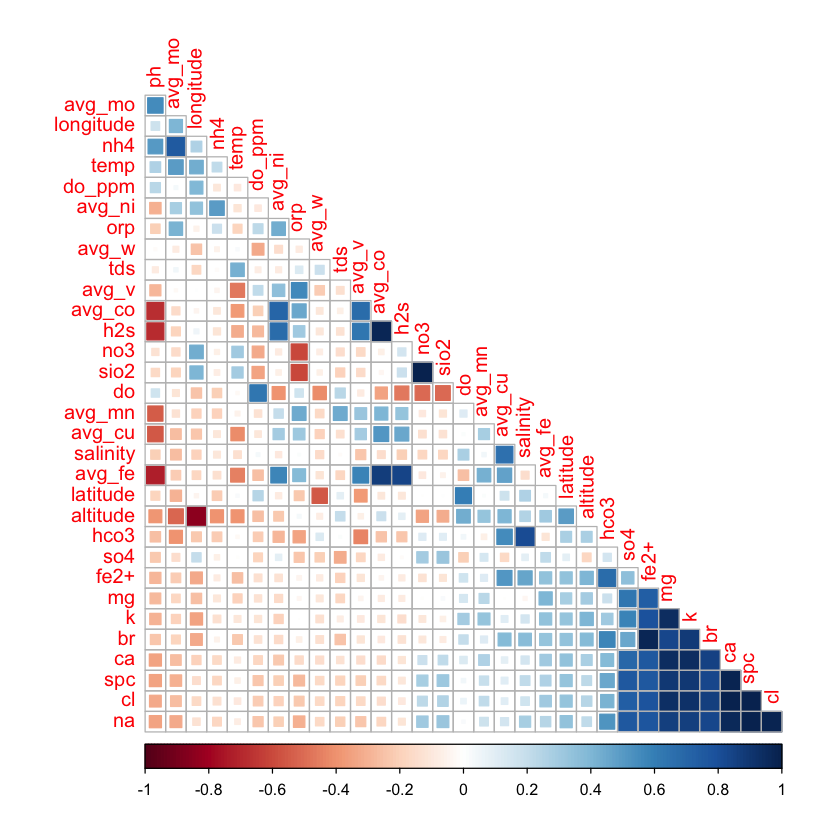

In [ ]:
corrplot(
    corr_matrix,
    method="square",
    order="FPC",
    type="lower",
    insig="blank",
    diag=FALSE
)

In [ ]:
pca_result = prcomp(features_df, scale = TRUE)

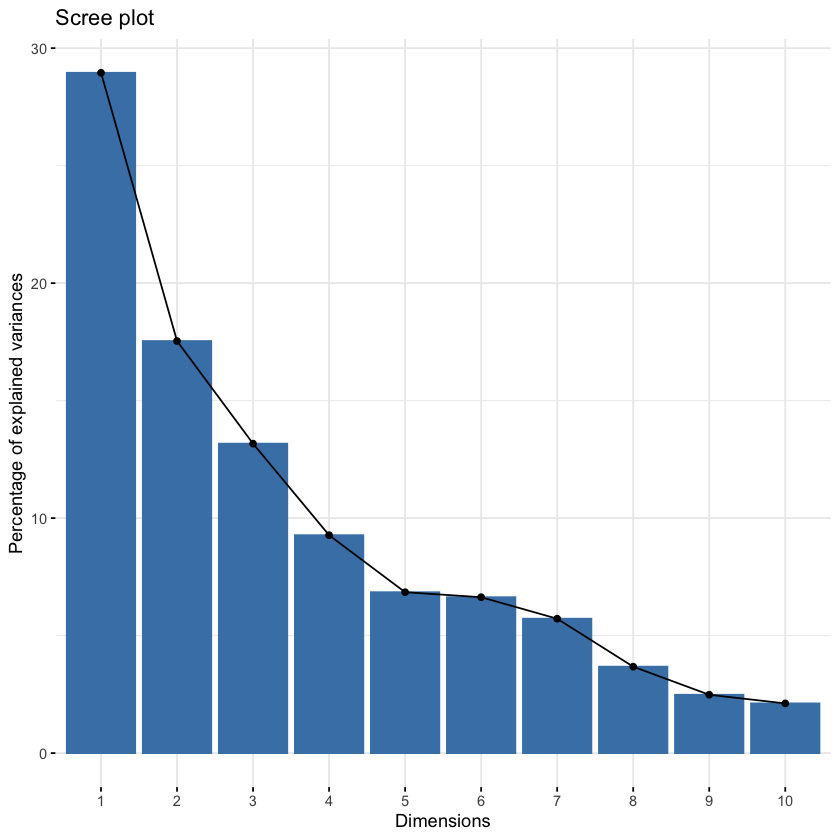

In [ ]:
fviz_eig(pca_result)

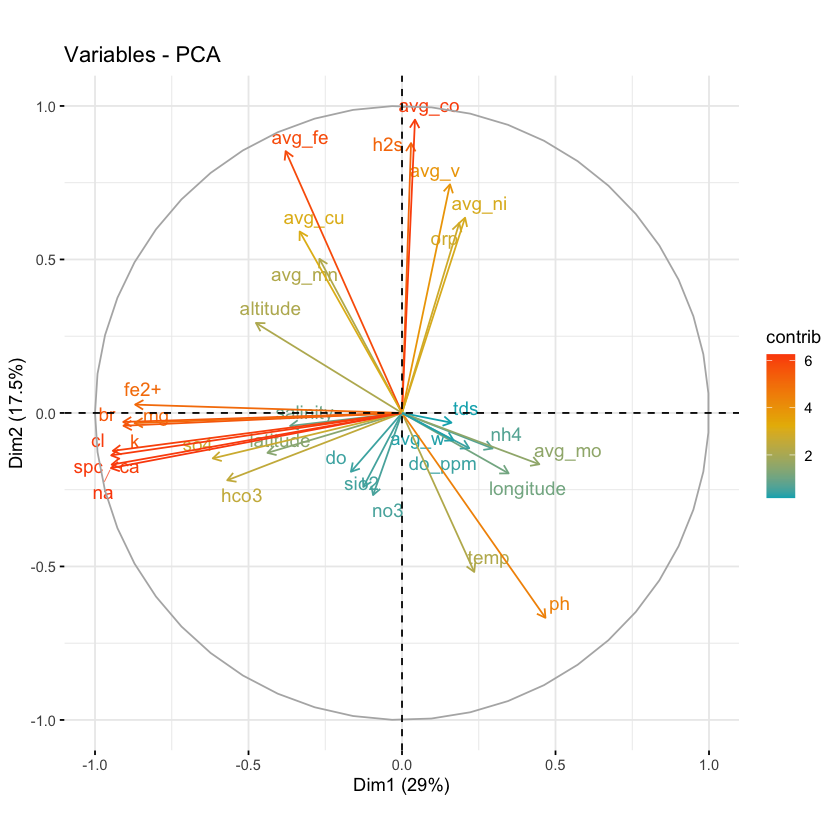

In [ ]:
fviz_pca_var(
    pca_result,
    col.var="contrib", # Color by contributions to the PC
    gradient.cols=c("#00AFBB", "#E7B800", "#FC4E07"),
    repel=TRUE # Avoid text overlapping
)

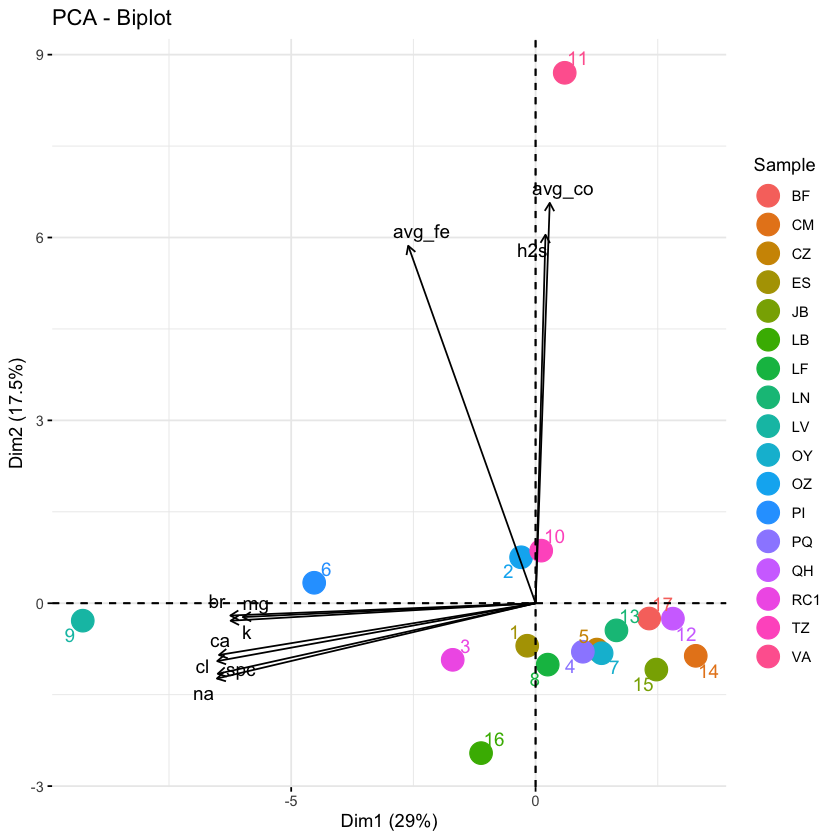

In [ ]:
fviz_pca_biplot(
    pca_result,
    col.ind=env_data_df$ID,    
    select.var=list(cos2=10),
    pointsize=3,
    pointshape=21,
    fill.ind=env_data_df$ID,
    col.var="black",
    repel=TRUE,
    legend.title="Sample"
)